In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import random
import scipy

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    sys.path.append(path)

from neurolib.models.aln import ALNModel
import neurolib.dashboard.data as data
from neurolib.models.aln import timeIntegration
from neurolib.utils import func_optimize as fo

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
aln = ALNModel()

data.set_parameters(aln)
aln.params.de = 0.
aln.params.di = 0.

aln.params.mue_ext_mean = 0.5 * 5.
aln.params.mue_ext_mean = 0.6 * 5.

dt = aln.params.dt

In [4]:
state_vars = aln.state_vars.copy()

def set_init(IC_, init_vars_, state_vars_):
    for iv in range(len(init_vars_)):
        if aln.params[init_vars_[iv]].ndim == 1:
            aln.params[init_vars_[iv]][:] = IC_[:, iv, -1]
        else:
            aln.params[init_vars_[iv]] = IC_[:, iv, :]

[0.93944456]


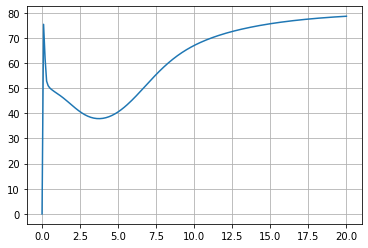

In [5]:
aln.params.duration = 20.
state_ = fo.updateFullState(aln, aln.getZeroControl(), aln.state_vars)
plt.plot(aln.t, aln.rates_exc[0,:])

init_state = np.zeros(( 1, 20, aln.getMaxDelay()+1 ))
for sv in range(20):
    init_state[0,sv,:] = state_[0,sv,-aln.getMaxDelay()-1:]
    
print(init_state[0,5,:])

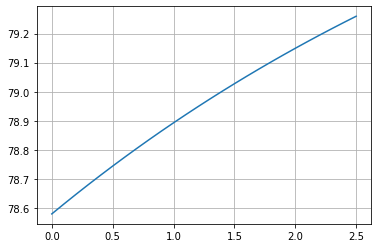

In [6]:
T = 25.*dt
aln.params.duration = T
set_init(init_state, aln.init_vars, aln.state_vars)
state_0 = fo.updateFullState(aln, aln.getZeroControl(), aln.state_vars)

plt.plot(aln.t, aln.rates_exc[0,:])
plt.show()

In [7]:
A_num = np.zeros(( 16, 16 ))
#A_E_num = np.zeros(( 20, 20 ))
#A_I_num = np.zeros(( 20, 20 ))
#B_num = np.zeros(( 20, 2 ))
C_num = np.zeros(( 16 ))

set_init(init_state, aln.init_vars, aln.state_vars)
state_0 = fo.updateFullState(aln, aln.getZeroControl(), aln.state_vars)
x0 = init_state.copy()

for j in [17,14,13,4]:
    state_0 = np.delete(state_0,j,axis=1)
    x0 = np.delete(x0,j,axis=1)
    
x0 = x0[0,:]
    
print(state_0.shape, x0.shape)

(1, 16, 26) (16, 1)


In [12]:
n_unknown = 17

for j in [0,1,12,13,14,15]:
#for j in [14]:

    A_ = np.zeros(( n_unknown,n_unknown ))
    x_ = np.zeros(( n_unknown ))
    
    for t in range(n_unknown):
        for k in range(n_unknown-1):
            A_[t,k] = state_0[0,k,t]
        A_[t,-1] = 1.
        x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt
                
    sol = np.linalg.solve(A_, x_)
    
    if np.amax(np.abs(np.matmul(A_, sol) - x_)) > 1e-8:
        print("WARNING: IMPRECISE COMPUTATION")
    
    for k in range(n_unknown-1):
        A_num[j,k] = sol[k]
    C_num[j] = sol[-1]
    
    print(j, "   ----------------- ")
    print(A_num[j,:])
    print(C_num[j])

0    ----------------- 
[-1.05857676e+01  5.69227510e+01  2.89493924e+02  3.51208876e+05
  5.03689654e+01 -2.28113362e+04 -7.79312755e+01  2.31722760e+04
 -7.01428275e+04 -1.46163223e+06  2.71741604e+05  5.00799468e+05
  1.48845891e+05 -4.60147452e+05  2.74221271e+00  7.34348860e+04]
-70826.06153855444
1    ----------------- 
[ 3.40173559e-06 -1.00079607e+01 -2.47755036e-04  1.89730631e+02
 -6.83044573e-02  1.09072930e+00  6.61804815e-02 -1.06338390e+00
  7.72553908e+00  1.36045022e+02 -9.33539441e+00 -1.88928899e+01
 -1.60788395e+01  3.05084196e+01 -4.63188893e-09 -4.04798086e+01]
134.84051376818317
12    ----------------- 
[-1.47114306e-05  1.02178831e-02 -6.00635917e-04  2.27170944e+01
 -5.33264853e-02 -1.06642307e+00 -2.96552096e-03  7.43700458e-01
 -1.11094058e+01 -8.42144032e+01  1.33776900e+01  2.42232415e+01
  8.17250337e+00 -2.25076547e+01 -3.39060791e-06  4.80330776e+00]
-13.178447096972521
13    ----------------- 
[-1.51711822e-05  3.11850528e-03 -8.05315302e-04 -2.16181881e

In [ ]:
X = A0_[:,:-1].copy()
XTX = np.matmul(np.transpose(X_shift), X_shift)

#v[:,i] is the eigenvector corresponding to the eigenvalue r[i]
r,v = np.linalg.eig(XTX)
v_sorted = np.zeros((v.shape))
r_sorted = np.zeros((r.shape))
sort_ind = []

#print('Eigenvalues = ', r)
#print('Eigenvectors = ', v)

while len(sort_ind) < len(r):
    max_ind = -1
    max_val = -1.
    for k in range(len(r)):
        if k in sort_ind:
            continue
        if np.abs(r[k]) > max_val:
            max_ind = k
            max_val = r[k]
    sort_ind.append(max_ind)
    
for k in range(len(sort_ind)):
    v_sorted[:,k] = v[:,sort_ind[k]]
    r_sorted[k] = r[sort_ind[k]]
    
print('Eigenvalues = ', r_sorted)
print('Eigenvectors = ', v_sorted)

# main axis: first column of v_sorted
pc = v_sorted[:,0]
print('principal component = ', pc)

Y = np.tensordot(X, pc, axes=1)
print(Y)
res = np.polyfit(x0_, Y, deg=1)
print(res)

In [80]:
n_unknown = 16
n_samples = 16

j=14
X = np.zeros(( n_samples,n_unknown ))
x_ = np.zeros(( n_samples ))

for t in range(n_samples):
    for k in range(n_unknown):
        X[t,k] = state_0[0,k,t]
    x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt

XTX = np.matmul(np.transpose(X), X)

#v[:,i] is the eigenvector corresponding to the eigenvalue r[i]
r,v = np.linalg.eig(XTX)
v_sorted = np.zeros((v.shape))
r_sorted = np.zeros((r.shape))
sort_ind = []

while len(sort_ind) < len(r):
    max_ind = -1
    max_val = -1.
    for k in range(len(r)):
        if k in sort_ind:
            continue
        if np.abs(r[k]) > max_val:
            max_ind = k
            max_val = r[k]
    sort_ind.append(max_ind)
    
for k in range(len(sort_ind)):
    v_sorted[:,k] = v[:,sort_ind[k]]
    r_sorted[k] = r[sort_ind[k]]
    
print('Eigenvalues = ', r_sorted)

pc = v_sorted[:,0]
print('principal component = ', pc)

Y = np.tensordot(X, pc, axes=1)
res = np.polyfit(x_, Y, deg=1)

A_num[j,:] = res[0] * pc[:]
C_num[j] = res[1]

print(j, "   ----------------- ")
print(A_num[j,:])
print(C_num[j])

Eigenvalues =  [ 1.09138841e+05  3.47467947e-02  1.91911702e-06  1.60799076e-10
  5.82366930e-12  1.30441881e-14  6.00358831e-15  4.37434687e-15
  1.69702208e-15  5.22521462e-19  4.66218346e-20  4.95249230e-22
 -2.57154864e-19 -3.16548287e-15 -1.09202173e-14 -1.58626391e-14]
principal component =  [9.54286952e-01 2.93335026e-01 3.20171078e-02 1.20308954e-02
 1.13768225e-02 9.51698936e-03 1.13289432e-02 1.06645850e-02
 2.71947696e-06 3.50808202e-05 2.86119840e-06 2.66735589e-05
 1.84201296e-02 1.81912046e-02 6.90756186e-03 3.06776329e-02]
14    ----------------- 
[-8.26895364e+01 -2.54176558e+01 -2.77430158e+00 -1.04248429e+00
 -9.85808492e-01 -8.24652833e-01 -9.81659715e-01 -9.24092684e-01
 -2.35644308e-04 -3.03977410e-03 -2.47924557e-04 -2.31127987e-03
 -1.59611527e+00 -1.57627879e+00 -5.98544376e-01 -2.65823528e+00]
82.3524105340681


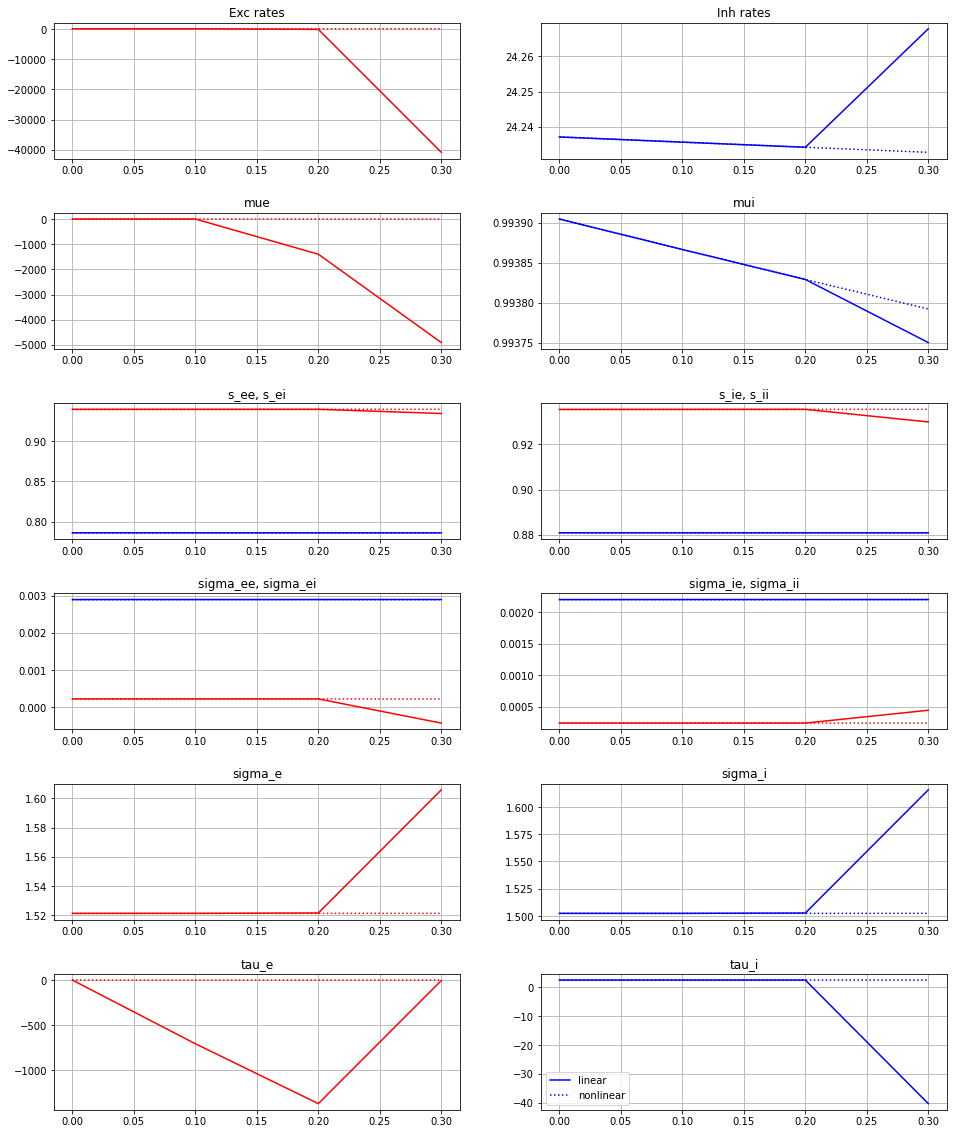

   -----  14
[ 5.72073101e-01 -7.04932717e+02 -1.36848895e+03]
[0.5720731  0.57192414 0.57177809]


In [81]:
x_forward = lin_forward(A_num, C_num, x0, T, dt)

T_end = 0.4
t_end = np.around(T_end/dt).astype(int)
time_array = np.arange(0., T_end, dt)

plot_compare(time_array, x_forward[:,:t_end], state_0[:,:,:t_end])

j=14
print("   ----- ", j)
print(x_forward[j,:3])
print(state_0[0,j,:3])

In [53]:
n_unknown = 5

j = 2

A_ = np.zeros(( n_unknown,n_unknown ))
x_ = np.zeros(( n_unknown ))

for t in range(n_unknown):
    A_[t,0] = state_0[0,2,t]
    A_[t,1] = state_0[0,4,t]
    A_[t,2] = state_0[0,5,t]
    A_[t,3] = state_0[0,14,t]
    A_[t,-1] = 1.
    x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt

sol = np.linalg.solve(A_, x_)

A_num[j,2] = sol[0]
A_num[j,4] = sol[1]
A_num[j,5] = sol[2]
A_num[j,14] = sol[3]
C_num[j] = sol[-1]

print(j, "   ----------------- ")
print(A_num[j,:])
print(C_num[j])

j = 3

A_ = np.zeros(( n_unknown,n_unknown ))
x_ = np.zeros(( n_unknown ))

for t in range(n_unknown):
    A_[t,0] = state_0[0,3,t]
    A_[t,1] = state_0[0,6,t]
    A_[t,2] = state_0[0,7,t]
    A_[t,3] = state_0[0,15,t]
    A_[t,-1] = 1.
    x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt

sol = np.linalg.solve(A_, x_)

A_num[j,3] = sol[0]
A_num[j,6] = sol[1]
A_num[j,7] = sol[2]
A_num[j,15] = sol[3]
C_num[j] = sol[-1]

print(j, "   ----------------- ")
print(A_num[j,:])
print(C_num[j])

2    ----------------- 
[   0.            0.            5.71177466    0.         -141.19866237
   20.42374104    0.            0.            0.            0.
    0.            0.            0.            0.           19.83826445
    0.        ]
90.19700002836454
3    ----------------- 
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.11128638e+02
  0.00000000e+00  0.00000000e+00 -6.06997723e-01  8.19934248e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.90052887e+02]
1380.211171444957


In [54]:
n_unknown = 3

j = 4

A_ = np.zeros(( n_unknown,n_unknown ))
x_ = np.zeros(( n_unknown ))

for t in range(n_unknown):
    A_[t,0] = state_0[0,0,t]
    A_[t,1] = state_0[0,4,t]
    A_[t,-1] = 1.
    x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt

sol = np.linalg.solve(A_, x_)

A_num[j,0] = sol[0]
A_num[j,4] = sol[1]
C_num[j] = sol[-1]

print(j, "   ----------------- ")
print(A_num[j,:])
print(C_num[j])

j = 5

A_ = np.zeros(( n_unknown,n_unknown ))
x_ = np.zeros(( n_unknown ))

for t in range(n_unknown):
    A_[t,0] = state_0[0,1,t]
    A_[t,1] = state_0[0,5,t]
    A_[t,-1] = 1.
    x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt

sol = np.linalg.solve(A_, x_)

A_num[j,1] = sol[0]
A_num[j,5] = sol[1]
C_num[j] = sol[-1]

print(j, "   ----------------- ")
print(A_num[j,:])
print(C_num[j])

j = 6

A_ = np.zeros(( n_unknown,n_unknown ))
x_ = np.zeros(( n_unknown ))

for t in range(n_unknown):
    A_[t,0] = state_0[0,0,t]
    A_[t,1] = state_0[0,6,t]
    A_[t,-1] = 1.
    x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt

sol = np.linalg.solve(A_, x_)

A_num[j,0] = sol[0]
A_num[j,6] = sol[1]
C_num[j] = sol[-1]

print(j, "   ----------------- ")
print(A_num[j,:])
print(C_num[j])

j = 7

A_ = np.zeros(( n_unknown,n_unknown ))
x_ = np.zeros(( n_unknown ))

for t in range(n_unknown):
    A_[t,0] = state_0[0,1,t]
    A_[t,1] = state_0[0,7,t]
    A_[t,-1] = 1.
    x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt

sol = np.linalg.solve(A_, x_)

A_num[j,1] = sol[0]
A_num[j,7] = sol[1]
C_num[j] = sol[-1]

print(j, "   ----------------- ")
print(A_num[j,:])
print(C_num[j])

4    ----------------- 
[ 2.69945981e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.70230433e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.51474077371498
5    ----------------- 
[ 0.          0.00631357  0.          0.          0.         -0.91281182
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
0.5644193934984783
6    ----------------- 
[ 2.89461433e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.73497311e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.5140181327666447
7    ----------------- 
[ 0.          0.00677456  0.          0.          0.          0.
  0.         -1.57294046  0.          0.          0.          0.
  0.     

In [55]:
n_unknown = 4

j = 8

A_ = np.zeros(( n_unknown,n_unknown ))
x_ = np.zeros(( n_unknown ))

for t in range(n_unknown):
    A_[t,0] = state_0[0,0,t]
    A_[t,1] = state_0[0,4,t]
    A_[t,2] = state_0[0,8,t]
    A_[t,-1] = 1.
    x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt
    
print(A_, x_)

sol = np.linalg.solve(A_, x_)

A_num[j,0] = sol[0]
A_num[j,4] = sol[1]
A_num[j,8] = sol[2]
C_num[j] = sol[-1]

print(j, "   ----------------- ")
print(A_num[j,:])
print(C_num[j])

j = 9

A_ = np.zeros(( n_unknown,n_unknown ))
x_ = np.zeros(( n_unknown ))

for t in range(n_unknown):
    A_[t,0] = state_0[0,1,t]
    A_[t,1] = state_0[0,5,t]
    A_[t,2] = state_0[0,9,t]
    A_[t,-1] = 1.
    x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt

sol = np.linalg.solve(A_, x_)

A_num[j,1] = sol[0]
A_num[j,5] = sol[1]
A_num[j,9] = sol[2]
C_num[j] = sol[-1]

print(j, "   ----------------- ")
print(A_num[j,:])
print(C_num[j])

j = 10

A_ = np.zeros(( n_unknown,n_unknown ))
x_ = np.zeros(( n_unknown ))

for t in range(n_unknown):
    A_[t,0] = state_0[0,0,t]
    A_[t,1] = state_0[0,6,t]
    A_[t,2] = state_0[0,10,t]
    A_[t,-1] = 1.
    x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt

sol = np.linalg.solve(A_, x_)

A_num[j,0] = sol[0]
A_num[j,6] = sol[1]
A_num[j,10] = sol[2]
C_num[j] = sol[-1]

print(j, "   ----------------- ")
print(A_num[j,:])
print(C_num[j])

j = 11

A_ = np.zeros(( n_unknown,n_unknown ))
x_ = np.zeros(( n_unknown ))

for t in range(n_unknown):
    A_[t,0] = state_0[0,1,t]
    A_[t,1] = state_0[0,7,t]
    A_[t,2] = state_0[0,11,t]
    A_[t,-1] = 1.
    x_[t] = ( state_0[0,j,t+1] - state_0[0,j,t] ) / dt

sol = np.linalg.solve(A_, x_)

A_num[j,1] = sol[0]
A_num[j,7] = sol[1]
A_num[j,11] = sol[2]
C_num[j] = sol[-1]

print(j, "   ----------------- ")
print(A_num[j,:])
print(C_num[j])

[[7.85809603e+01 9.39444557e-01 2.25866147e-04 1.00000000e+00]
 [7.86151160e+01 9.39469908e-01 2.25680915e-04 1.00000000e+00]
 [7.86485953e+01 9.39494736e-01 2.25499583e-04 1.00000000e+00]
 [7.86814119e+01 9.39519051e-01 2.25322062e-04 1.00000000e+00]] [-1.85231343e-06 -1.81332518e-06 -1.77521037e-06 -1.73797686e-06]
8    ----------------- 
[ 3.35899492e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.47920979e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.42614474e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.13954335416847094
9    ----------------- 
[ 0.00000000e+00  1.98660724e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.94676714e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.57256370e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.03509972856847646
10    ----------------- 
[-1.05548297e-05  0.00000000e+00  0.00000000e+

(16, 1)


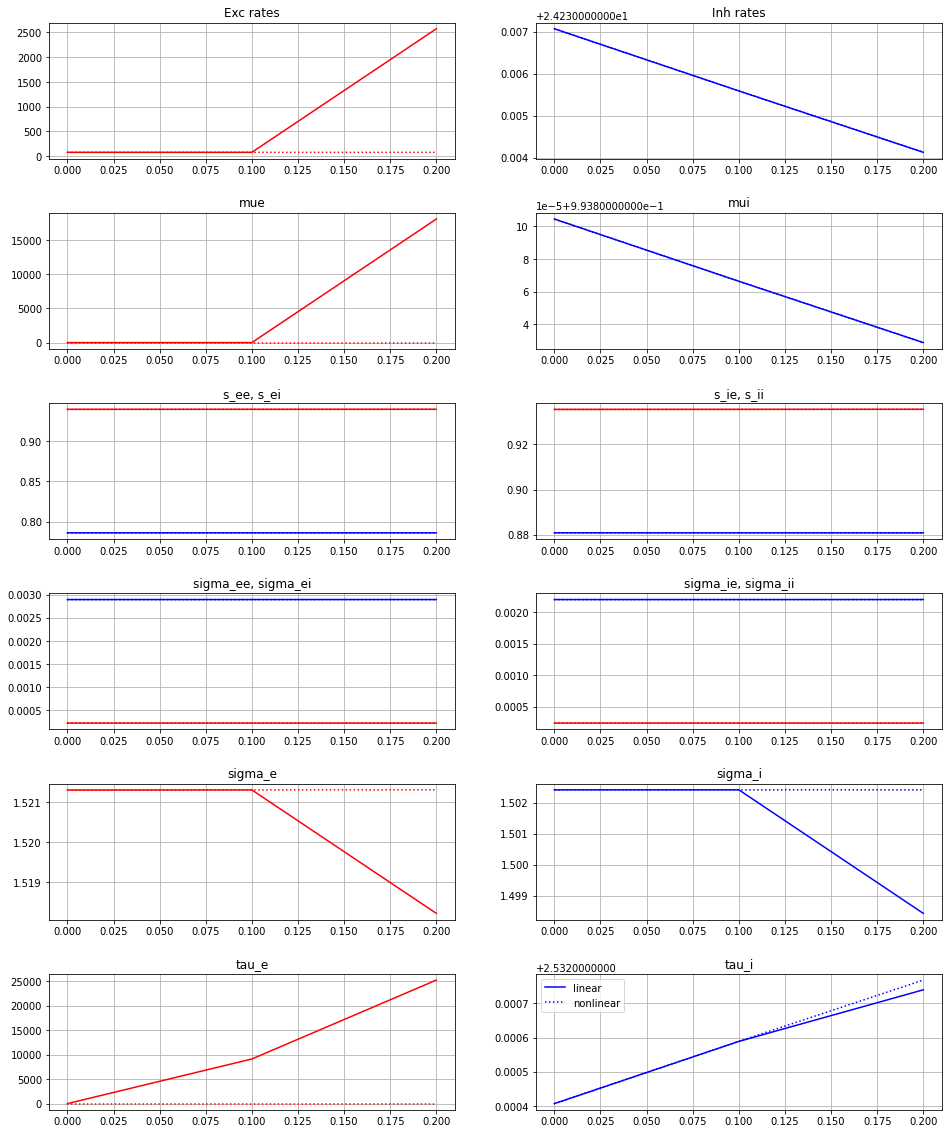

   -----  0
[  78.58096034   78.61511598 2574.71069981]
[78.58096034 78.61511598 78.64859526]
   -----  1
[24.2370677  24.23558758 24.23412452]
[24.2370677  24.23558758 24.23412873]
   -----  2
[2.63645307e+00 2.63759871e+00 1.80601511e+04]
[2.63645307 2.63759871 2.63872167]
   -----  3
[0.99390449 0.99386643 0.99382893]
[0.99390449 0.99386643 0.99382893]
   -----  4
[0.93944456 0.93946991 0.93949474]
[0.93944456 0.93946991 0.93949474]
   -----  5
[0.78609535 0.78608381 0.78607239]
[0.78609535 0.78608381 0.78607239]
   -----  6
[0.9354793  0.93550625 0.93553263]
[0.9354793  0.93550625 0.93553263]
   -----  7
[0.88084258 0.88083564 0.8808288 ]
[0.88084258 0.88083564 0.8808288 ]
   -----  8
[0.00022587 0.00022568 0.0002255 ]
[0.00022587 0.00022568 0.0002255 ]
   -----  9
[0.0028953  0.00289558 0.00289586]
[0.0028953  0.00289558 0.00289586]
   -----  10
[0.00023763 0.00023744 0.00023725]
[0.00023763 0.00023744 0.00023725]
   -----  11
[0.00220123 0.00220148 0.00220172]
[0.00220123 0.00220

In [73]:
print(x0.shape)

x_forward = lin_forward(A_num, C_num, x0, T, dt)

T_end = 0.3
t_end = np.around(T_end/dt).astype(int)
time_array = np.arange(0., T_end, dt)

plot_compare(time_array, x_forward[:,:t_end], state_0[:,:,:t_end])

j=14
print("   ----- ", j)
print(x_forward[j,:3])
print(state_0[0,j,:3])
    
### -0.001434326171875 0.5720689268433112

In [70]:
def plot_compare(time_array, s0, s1):
    fig, ax = plt.subplots(6,2, figsize=(16,20))
    fig.subplots_adjust(hspace=0.4)

    ax[0,0].set_title('Exc rates')
    ax[0,0].plot(time_array, s0[0,:], color='red', label='linear')
    ax[0,0].plot(time_array, s1[0,0,:], color = 'red', linestyle=':', label='nonlinear')
    ax[0,1].set_title('Inh rates')
    ax[0,1].plot(time_array, s0[1,:], color='blue', label='linear')
    ax[0,1].plot(time_array, s1[0,1,:], color = 'blue', linestyle=':', label='nonlinear')

    ax[1,0].set_title('mue')
    ax[1,0].plot(time_array, s0[2,:], color='red', label='linear')
    ax[1,0].plot(time_array, s1[0,2,:], color = 'red', linestyle=':', label='nonlinear')
    ax[1,1].set_title('mui')
    ax[1,1].plot(time_array, s0[3,:], color='blue', label='linear')
    ax[1,1].plot(time_array, s1[0,3,:], color = 'blue', linestyle=':', label='nonlinear')

    ax[2,0].set_title('s_ee, s_ei')
    ax[2,0].plot(time_array, s0[4,:], color='red', label='linear')
    ax[2,0].plot(time_array, s1[0,4,:], color = 'red', linestyle=':', label='nonlinear')
    ax[2,0].plot(time_array, s0[5,:], color='blue', label='linear')
    ax[2,0].plot(time_array, s1[0,5,:], color = 'blue', linestyle=':', label='nonlinear')
    ax[2,1].set_title('s_ie, s_ii')
    ax[2,1].plot(time_array, s0[6,:], color='red', label='linear')
    ax[2,1].plot(time_array, s1[0,6,:], color = 'red', linestyle=':', label='nonlinear')
    ax[2,1].plot(time_array, s0[7,:], color='blue', label='linear')
    ax[2,1].plot(time_array, s1[0,7,:], color = 'blue', linestyle=':', label='nonlinear')

    ax[3,0].set_title('sigma_ee, sigma_ei')
    ax[3,0].plot(time_array, s0[8,:], color='red', label='linear')
    ax[3,0].plot(time_array, s1[0,8,:], color = 'red', linestyle=':', label='nonlinear')
    ax[3,0].plot(time_array, s0[9,:], color='blue', label='linear')
    ax[3,0].plot(time_array, s1[0,9,:], color = 'blue', linestyle=':', label='nonlinear')
    ax[3,1].set_title('sigma_ie, sigma_ii')
    ax[3,1].plot(time_array, s0[10,:], color='red', label='linear')
    ax[3,1].plot(time_array, s1[0,10,:], color = 'red', linestyle=':', label='nonlinear')
    ax[3,1].plot(time_array, s0[11,:], color='blue', label='linear')
    ax[3,1].plot(time_array, s1[0,11,:], color = 'blue', linestyle=':', label='nonlinear')

    ax[4,0].set_title('sigma_e')
    ax[4,0].plot(time_array, s0[12,:], color='red', label='linear')
    ax[4,0].plot(time_array, s1[0,12,:], color = 'red', linestyle=':', label='nonlinear')
    ax[4,1].set_title('sigma_i')
    ax[4,1].plot(time_array, s0[13,:], color='blue', label='linear')
    ax[4,1].plot(time_array, s1[0,13,:], color = 'blue', linestyle=':', label='nonlinear')

    ax[5,0].set_title('tau_e')
    ax[5,0].plot(time_array, s0[14,:], color='red', label='linear')
    ax[5,0].plot(time_array, s1[0,14,:], color = 'red', linestyle=':', label='nonlinear')
    ax[5,1].set_title('tau_i')
    ax[5,1].plot(time_array, s0[15,:], color='blue', label='linear')
    ax[5,1].plot(time_array, s1[0,15,:], color = 'blue', linestyle=':', label='nonlinear')

    plt.legend()
    plt.show()

In [57]:
def lin_forward(A_, C_, x0, T_, dt_):
    x_ = np.zeros(( A_.shape[0], int(T_/dt + 1 ) ))
    x_[:,0] = x0[:,0]
    
    for t_ in range(1, x_.shape[1]):
        x_[:,t_] = ( np.matmul(A_, x_[:,t_-1]) + C_[:] ) *dt + x_[:,t_-1]
        
    #j = 14
    #print(np.matmul(A_[j,:], x_[:,0]) + C_[j], x_[j,0])
    #print( (np.matmul(A_[j,:], x_[:,0]) + C_[j]) * dt + x_[j,0])
            
    return x_

In [183]:
def lin_backward(A_, C_, x0, T_, dt_):
    x_ = np.zeros(( A_.shape[0], int(T_/dt + 1 ) ))
    x_[:,-1] = x0[:,0]
    
    for t_ in range(-2, -x_.shape[1], -1):
        print(t_)
        x_[:,t_] = - ( np.matmul(A_, x_[:,t_+1]) + C_[:] ) *dt + x_[:,t_+1]
        print(x_[0,:])
        
    #j = 14
    #print(np.matmul(A_[j,:], x_[:,0]) + C_[j], x_[j,0])
    #print( (np.matmul(A_[j,:], x_[:,0]) + C_[j]) * dt + x_[j,0])
            
    return x_

-2
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 80.06121077 80.06575305]
-3
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         80.05684246
 80.06121077 80.06575305]
-4
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         80.05240248 80.05684246
 80.06121077 80.06575305]
-5
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         

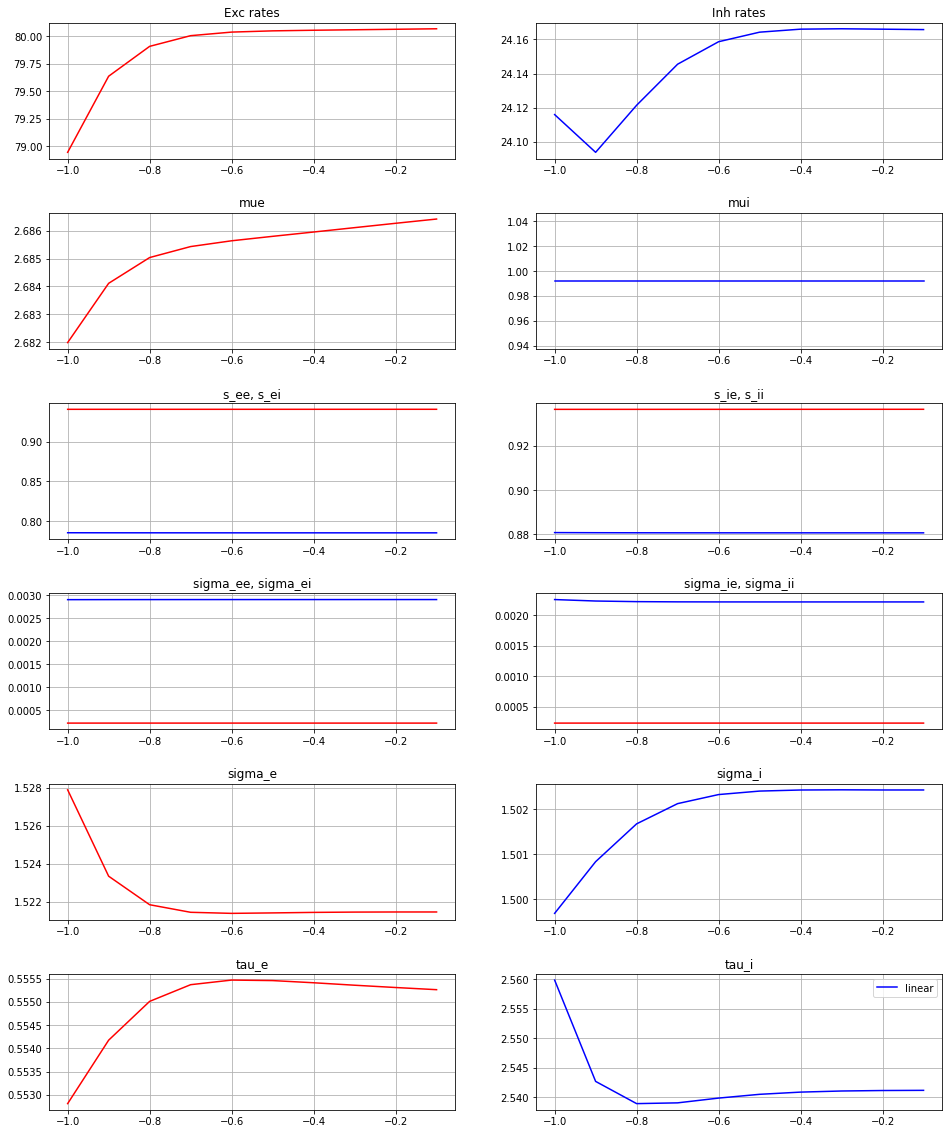

   -----  0
[80.06575305 80.07029532 80.07501157]
[80.06575305 80.07029532 80.0747468 ]
   -----  1
[24.16570906 24.16546991 24.16522824]
[24.16570906 24.16546991 24.16523543]
   -----  2
[2.68642208 2.68657529 2.68672543]
[2.68642208 2.68657529 2.68672543]
   -----  3
[0.99207526 0.99207526 0.99207526]
[0.99207526 0.99206914 0.99206314]
   -----  4
[0.94052704 0.94053029 0.94053348]
[0.94052704 0.94053029 0.94053348]
   -----  5
[0.78549801 0.7854959  0.78549384]
[0.78549801 0.7854959  0.78549384]
   -----  6
[0.93662977 0.93663322 0.93663661]
[0.93662977 0.93663322 0.93663661]
   -----  7
[0.88049838 0.8804972  0.88049604]
[0.88049838 0.8804972  0.88049604]
   -----  8
[0.00021802 0.000218   0.00021798]
[0.00021802 0.000218   0.00021798]
   -----  9
[0.00291083 0.00291089 0.00291094]
[0.00291083 0.00291089 0.00291094]
   -----  10
[0.00022941 0.00022939 0.00022936]
[0.00022941 0.00022939 0.00022936]
   -----  11
[0.00221377 0.00221381 0.00221386]
[0.00221377 0.00221381 0.00221386]
  

In [185]:
x_backward = lin_backward(A_num, C_num, x0, T, dt)

fig, ax = plt.subplots(6,2, figsize=(16,20))
fig.subplots_adjust(hspace=0.4)

T_end = -1.
t_end = np.around(T_end/dt).astype(int)
time_array = np.arange(T_end, 0., dt)

ax[0,0].set_title('Exc rates')
ax[0,0].plot(time_array, x_backward[0,t_end:], color='red', label='linear')
#ax[0,0].plot(time_array, state_0[0,0,:t_end], color = 'red', linestyle=':', label='nonlinear')
ax[0,1].set_title('Inh rates')
ax[0,1].plot(time_array, x_backward[1,t_end:], color='blue', label='linear')
#ax[0,1].plot(time_array, state_0[0,1,:t_end], color = 'blue', linestyle=':', label='nonlinear')

ax[1,0].set_title('mue')
ax[1,0].plot(time_array, x_backward[2,t_end:], color='red', label='linear')
#ax[1,0].plot(time_array, state_0[0,2,:t_end], color = 'red', linestyle=':', label='nonlinear')
ax[1,1].set_title('mui')
ax[1,1].plot(time_array, x_backward[3,t_end:], color='blue', label='linear')
#ax[1,1].plot(time_array, state_0[0,3,:t_end], color = 'blue', linestyle=':', label='nonlinear')

ax[2,0].set_title('s_ee, s_ei')
ax[2,0].plot(time_array, x_backward[4,t_end:], color='red', label='linear')
#ax[2,0].plot(time_array, state_0[0,4,:t_end], color = 'red', linestyle=':', label='nonlinear')
ax[2,0].plot(time_array, x_backward[5,t_end:], color='blue', label='linear')
#ax[2,0].plot(time_array, state_0[0,5,:t_end], color = 'blue', linestyle=':', label='nonlinear')
ax[2,1].set_title('s_ie, s_ii')
ax[2,1].plot(time_array, x_backward[6,t_end:], color='red', label='linear')
#ax[2,1].plot(time_array, state_0[0,6,:t_end], color = 'red', linestyle=':', label='nonlinear')
ax[2,1].plot(time_array, x_backward[7,t_end:], color='blue', label='linear')
#ax[2,1].plot(time_array, state_0[0,7,:t_end], color = 'blue', linestyle=':', label='nonlinear')

ax[3,0].set_title('sigma_ee, sigma_ei')
ax[3,0].plot(time_array, x_backward[8,t_end:], color='red', label='linear')
#ax[3,0].plot(time_array, state_0[0,8,:t_end], color = 'red', linestyle=':', label='nonlinear')
ax[3,0].plot(time_array, x_backward[9,t_end:], color='blue', label='linear')
#ax[3,0].plot(time_array, state_0[0,9,:t_end], color = 'blue', linestyle=':', label='nonlinear')
ax[3,1].set_title('sigma_ie, sigma_ii')
ax[3,1].plot(time_array, x_backward[10,t_end:], color='red', label='linear')
#ax[3,1].plot(time_array, state_0[0,10,:t_end], color = 'red', linestyle=':', label='nonlinear')
ax[3,1].plot(time_array, x_backward[11,t_end:], color='blue', label='linear')
#ax[3,1].plot(time_array, state_0[0,11,:t_end], color = 'blue', linestyle=':', label='nonlinear')

ax[4,0].set_title('sigma_e')
ax[4,0].plot(time_array, x_backward[12,t_end:], color='red', label='linear')
#ax[4,0].plot(time_array, state_0[0,12,:t_end], color = 'red', linestyle=':', label='nonlinear')
ax[4,1].set_title('sigma_i')
ax[4,1].plot(time_array, x_backward[13,t_end:], color='blue', label='linear')
#ax[4,1].plot(time_array, state_0[0,13,:t_end], color = 'blue', linestyle=':', label='nonlinear')

ax[5,0].set_title('tau_e')
ax[5,0].plot(time_array, x_backward[14,t_end:], color='red', label='linear')
#ax[5,0].plot(time_array, state_0[0,14,:t_end], color = 'red', linestyle=':', label='nonlinear')
ax[5,1].set_title('tau_i')
ax[5,1].plot(time_array, x_backward[15,t_end:], color='blue', label='linear')
#ax[5,1].plot(time_array, state_0[0,15,:t_end], color = 'blue', linestyle=':', label='nonlinear')

plt.legend()
plt.show()